In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.misc
import numpy as np
import pandas as pd
import caffe
import cv2
import skfmm
import PIL.Image


import lib.imageutl as imutl
import lib.visualizationutl as view
import lib.netutility as netutl
import nettest


In [2]:
pathdataset = '../db'
namedataset = 'car'
metadata = 'metadata.csv'
path_model = '../net' #net model path
name_modelproto = 'deploy.prototxt'
name_modelcaffe = 'model.caffemodel'

pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)
modelproto = os.path.join(path_model,name_modelproto);
modelcaffe = os.path.join(path_model,name_modelcaffe);

print(pathname)
print(modelproto)
print(modelcaffe)

../db/car
../net/deploy.prototxt
../net/model.caffemodel


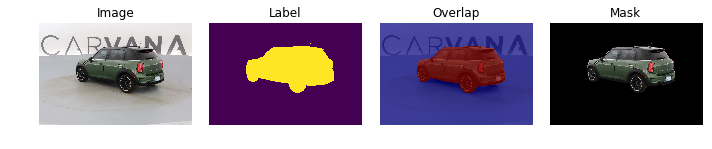

In [15]:
#data = imutl.imageProvide(pathname, fn_image='train' )
data = imutl.dataProvide( pathname, ext='jpg', fn_image='train', fn_label='train_masks', lext='gif')
view.display_image_and_gt(data)

In [16]:
caffe.set_mode_cpu();
net = caffe.Net(modelproto, modelcaffe, caffe.TEST);
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 1024, 1024)),
 ('tdata', (1, 3, 1024, 1024)),
 ('tdata_tdata_0_split_0', (1, 3, 1024, 1024)),
 ('tdata_tdata_0_split_1', (1, 3, 1024, 1024)),
 ('data_preprocessed', (1, 3, 1024, 1024)),
 ('conv1', (1, 96, 304, 304)),
 ('pool1', (1, 96, 152, 152)),
 ('norm1', (1, 96, 152, 152)),
 ('conv2', (1, 256, 152, 152)),
 ('pool2', (1, 256, 76, 76)),
 ('norm2', (1, 256, 76, 76)),
 ('conv3', (1, 384, 76, 76)),
 ('conv4', (1, 384, 76, 76)),
 ('conv5', (1, 256, 76, 76)),
 ('pool5', (1, 256, 38, 38)),
 ('fc6', (1, 4096, 33, 33)),
 ('fc7', (1, 4096, 33, 33)),
 ('score_fr', (1, 2, 33, 33)),
 ('upscore', (1, 2, 1087, 1087)),
 ('score', (1, 2, 1024, 1024)),
 ('prob', (1, 2, 1024, 1024))]

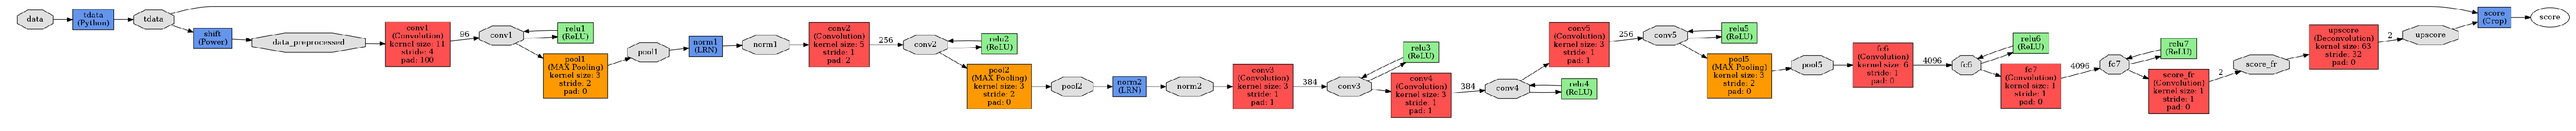

In [5]:
from google.protobuf import text_format
import caffe.draw
from caffe.proto import caffe_pb2
from PIL import Image

nnet = caffe_pb2.NetParameter();
text_format.Merge( open( os.path.join(modelproto) ).read(), nnet);
caffe.draw.draw_net_to_file(nnet, 'my_net.png', 'LR');

image_net = Image.open('my_net.png');
image_net.load();

fig = plt.figure(figsize=(100, 100))
plt.imshow(image_net);
plt.axis('off')
plt.show();

In [28]:
def transform_image_size(image, size):

    height, width, channels = image.shape;
    image = np.array(image)
    
    asp = float(height)/width;
    w = size; 
    h = int(w*asp);
    
    image_x = scipy.misc.imresize(image.copy(), (h,w), interp='bilinear');
    image = np.zeros((w,w,3));
    ini = int(round((w-h) / 2.0));
    image[ini:h+ini,:,:] = image_x;
    image = image.astype(np.uint8);

    return image, asp;

image_org = data.getimage( np.random.randint(data.num) );
label_org = data.getlabel()

image, asp = transform_image_size(image_org, net.blobs['data'].data.shape[-1])
im_input = image[np.newaxis, :, :].transpose(0,3,1,2);
print(im_input.shape)

net.blobs['data'].data[...] = im_input;
out = net.forward();

print(out.keys())


(1, 3, 1024, 1024)
['prob']


[0 1]
(1024, 1024)


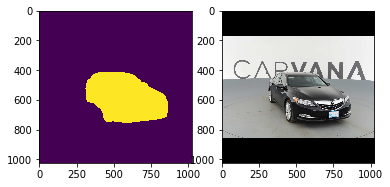

In [29]:
# assume the only output is a CHW image where C is the number
# of classes, H and W are the height and width of the image
class_data = out[out.keys()[0]].astype('float32')
class_data = class_data[0,:,:,:];

# retain only the top class for each pixel
class_data = np.argmax(class_data, axis=0).astype('uint8')

# remember the classes we found
found_classes = np.unique(class_data)

print(found_classes)
print(class_data.shape)

plt.subplot(121)
plt.imshow(class_data)
plt.subplot(122)
plt.imshow(image)
plt.show()

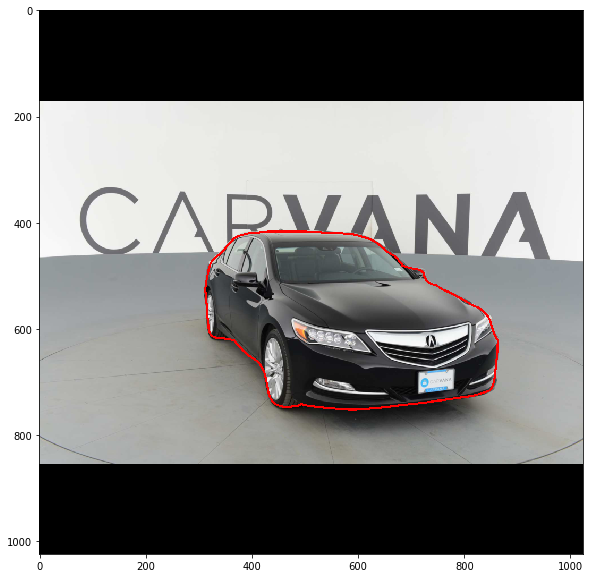

In [30]:

fill_data = np.ndarray((class_data.shape[0], class_data.shape[1], 4), dtype='uint8')
for x in xrange(3):
    fill_data[:, :, x] = class_data.copy()

# Assuming that class 0 is the background
mask = np.greater(class_data, 0)
fill_data[:, :, 3] = mask * 255
line_data = fill_data.copy()
seg_data = fill_data.copy()

# Black mask of non-segmented pixels
mask_data = np.zeros(fill_data.shape, dtype='uint8')
mask_data[:, :, 3] = (1 - mask) * 255

# Generate outlines around segmented classes
if len(found_classes) > 1:
    # Assuming that class 0 is the background.
    line_mask = np.zeros(class_data.shape, dtype=bool)
    max_distance = np.zeros(class_data.shape, dtype=float) + 1
    for c in (x for x in found_classes if x != 0):
        c_mask = np.equal(class_data, c)
        # Find the signed distance from the zero contour
        distance = skfmm.distance(c_mask.astype('float32') - 0.5)
        # Accumulate the mask for all classes
        line_width = 4
        line_mask |= c_mask & np.less(distance, line_width)
        max_distance = np.maximum(max_distance, distance + 128)

        line_data[:, :, 3] = line_mask * 255
        max_distance = np.maximum(max_distance, np.zeros(max_distance.shape, dtype=float))
        max_distance = np.minimum(max_distance, np.zeros(max_distance.shape, dtype=float) + 255)
        seg_data[:, :, 3] = max_distance


image_sh = image.copy()
image_sh[line_mask,:] = [255,0,0];
        
plt.figure(figsize=(10, 10))
plt.imshow(image_sh)
plt.show()



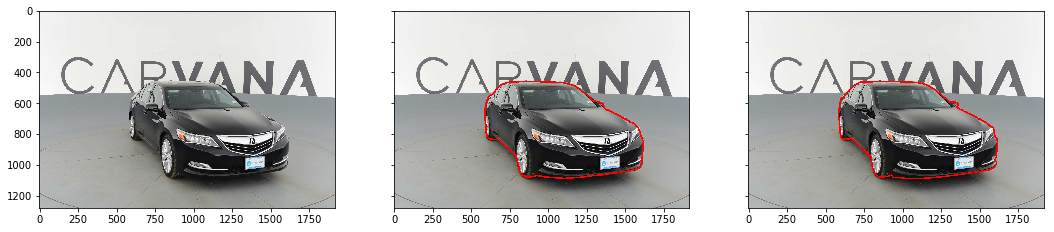

(1280, 1918)
(1280, 1918)
0.667361835245
0.667361835245
0.667361835245


In [31]:

def inv_transform_image_size(image, imshape, asp):
    
    height, width = image.shape;
    image = np.array(image);    
    w = height; 
    h = int(width*(asp));    
    ini = int(round((w-h) / 2.0));
    image_x = image[ini:h+ini,:];
    image_x = scipy.misc.imresize(image_x, imshape, interp='nearest', mode='F');
    image = image.astype(np.uint8);
    
    return image_x;


prediction = out[out.keys()[0]].astype('float32')
prediction = prediction[0,:,:,:];
prediction = np.argmax(prediction, axis=0).astype('uint8')
prediction = np.equal(prediction, 1).astype('uint8')
label_hat = inv_transform_image_size(prediction, label_org.shape, asp)


fig, ax = plt.subplots(1, 3, figsize=(18, 18), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(image_org)
ax[1].imshow(netutl.drawsegcontour(image_org,label_hat, line_width = 10))
ax[2].imshow(netutl.drawsegcontour(image_org,(label_org/255).astype(np.uint8), line_width=10 ))
plt.show()


print(label_hat.shape)
print(label_org.shape)
print(float(label_hat.shape[0])/label_hat.shape[1])
print(float(image_org.shape[0])/image_org.shape[1])
print(asp)


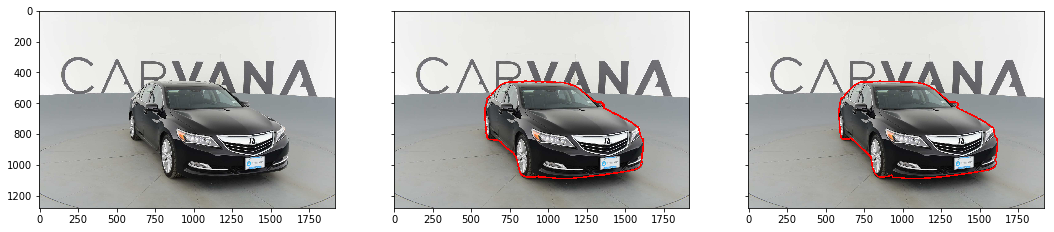

In [32]:
#Condicional random field
import pydensecrf.densecrf as dcrf

def crf( image, label):

    n_label   = label.shape[1]
    im_height = label.shape[2]
    im_width  = label.shape[3]

    d = dcrf.DenseCRF2D(im_height, im_width, n_label)
    U = label.reshape((n_label,-1)) # Needs to be flat..reshape((n_label, im_height*im_width))
    Up = (U+0.001) / (np.sum(U, axis=0))
    
    img_np = image
    img_np = img_np.copy(order='C')

    # change to negative log probability for numerical reasons
    d.setUnaryEnergy(-np.log(Up))
    # gaussian pairwise potential
    d.addPairwiseGaussian(3, 1.5) # sigma_xy, comp # 3 1.5
    # bilateral pairwise potential
    d.addPairwiseBilateral(60, 10, img_np, 3)  # 60 10 3
    Q = d.inference(50)
    Q = np.array(Q).reshape((n_label, im_height, im_width))
    out_label = np.argmax(Q, axis=0)
    
    return out_label


y_hat = out[out.keys()[0]].astype('float32')
y_hat_p = crf(image, y_hat)
label_hat_p = inv_transform_image_size(y_hat_p, label_org.shape, asp)
 
fig, ax = plt.subplots(1, 3, figsize=(18, 18), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(image_org)
ax[1].imshow(netutl.drawsegcontour(image_org,label_hat_p, line_width = 10))
ax[2].imshow(netutl.drawsegcontour(image_org,(label_org/255).astype(np.uint8), line_width=10 ))
plt.show()
    

In [33]:

def metric_dicecoef(label, prediction):
    '''
    Dice coefficient
    '''
    #label = bottom[1].data[:,0,:,:]
    # compute prediction
    #prediction = np.argmax(bottom[0].data, axis=1)
    # area of predicted contour
    a_p = np.sum(prediction, axis=(0,1))
    # area of contour in label
    a_l = np.sum(label, axis=(0,1))
    # area of intersection
    a_pl = np.sum(prediction * label, axis=(0,1))
    # dice coefficient
    dice_coeff = np.mean(2.*a_pl/(a_p + a_l))
    
    return dice_coeff

label_org = (label_org/255).astype(np.uint8)

print('Metric:')
print(metric_dicecoef(label_org, label_hat))
print(metric_dicecoef(label_org, label_hat_p))

#plt.imshow(label)
#plt.show()


Metric:
0.994700321259
0.99543298893


In [3]:
rls, dice = nettest.validation();

print( np.mean(dice) )
df = pd.DataFrame(rls)
df.to_csv('test.csv', index=False, encoding='utf-8')


iteration: 0 0.993353247921
0.994141699127


In [4]:
import nettest
import pandas as pd
#rls = nettest.test();

df = pd.DataFrame(rls)
df.to_csv('test.csv', index=False, encoding='utf-8')


